# A gentle introduction to iterative ensemble smoothers

In [1]:
%matplotlib inline
import os, shutil
import sys
sys.path.append("..")
import numpy as np
from IPython.display import Image
import pandas as pd
import matplotlib.pyplot as plt

import flopy as flopy
import pyemu

## using the K-R model since we can plot parameter space

In [2]:
import freyberg_setup as fs
fs.setup_pest_kr()
working_dir = fs.WORKING_DIR_KR
pst_name = fs.PST_NAME_KR

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...

changing model workspace...
   freyberg_kr
FloPy is using the following executable to run the model: /Users/jeremyw/Dev/gw1876/activities/freyberg_ies/freyberg_kr/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.1.1, 7/21/2016                        
                    BASED ON MODFLOW-2005 Version 1.11.0 08/08/2013                       

                    SWR1 Version 1.04.0 07/21/2016                       

 Using NAME file: freyberg.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/04/22 15:36:07

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Groundwater

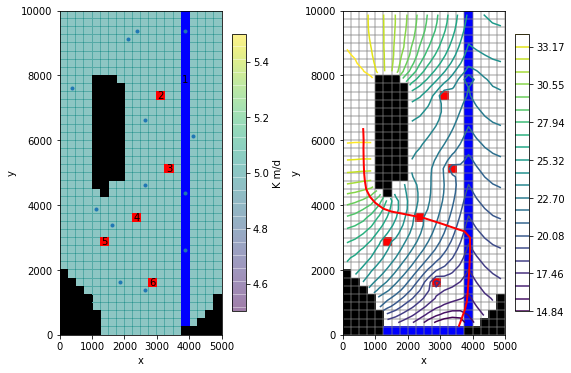

In [3]:
fs.plot_model(working_dir, pst_name)

## unfix ``rch_0`` and reset bounds to be consistent with the response surface plot

In [4]:
# m = flopy.modflow.Modflow.load(fs.MODEL_NAM,model_ws=working_dir,load_only=["upw"],check=False)
pst = pyemu.Pst(os.path.join(working_dir,pst_name))
par = pst.parameter_data
pst.parameter_data.loc["rch_0","partrans"] = 'log'
pst.parameter_data
par.loc['hk', 'parlbnd'] = 3
par.loc['hk', 'parubnd'] = 12
pst.observation_data.loc[pst.nnz_obs_names,:]

,obsnme,obsval,weight,obgnme,extra
obsnme,,,,,
c001cr03c10_19700102,c001cr03c10_19700102,26.661526,5.00,calhead,NaN
c001cr03c16_19700102,c001cr03c16_19700102,23.460564,5.00,calhead,NaN
c001cr04c09_19700102,c001cr04c09_19700102,28.513522,5.00,calhead,NaN
c001cr10c02_19700102,c001cr10c02_19700102,30.741689,5.00,calhead,NaN
c001cr14c11_19700102,c001cr14c11_19700102,25.871208,5.00,calhead,NaN
c001cr16c17_19700102,c001cr16c17_19700102,19.817240,5.00,calhead,NaN
c001cr22c11_19700102,c001cr22c11_19700102,24.858561,5.00,calhead,NaN
c001cr23c16_19700102,c001cr23c16_19700102,19.509003,5.00,calhead,NaN
c001cr25c05_19700102,c001cr25c05_19700102,25.251713,5.00,calhead,NaN


### run pestpp-ies

The iterative ensemble smoother can be thought of as a blend of deterministic gauss-levenburg-marquardt and monte carlo.  In short, we use an ensemble of parameters instead of a single parameter set and we use an ensemble of observations + realizations of measurement noise as "targets".  Let's see it in action:

In [11]:
pst.pestpp_options = {"forecasts":pst.pestpp_options["forecasts"]} #reset pestpp options
pst.pestpp_options["ies_subset_size"] = 3 #run only the first 4 realizations to test phis
pst.pestpp_options["ies_lambda_mults"] = [0.1,1.0,10.0] # test several lambda values
pst.pestpp_options["lambda_scale_fac"] = [0.95,1.1] #test some line searches along each lambda
pst.pestpp_options["ies_num_reals"] = 20 #num of realizations
pst.pestpp_options["par_sigma_range"] = 3 # parameter bounds represent 3 stds
#pst.pestpp_options["ies_reg_factor"] = 2000.0 # regularization portion of composite phi
pst.control_data.noptmax = 4
pst.write(os.path.join(working_dir,pst_name))

In [12]:
os.chdir(working_dir)
pyemu.helpers.start_slaves(".","pestpp-ies",pst_name,num_slaves=15,master_dir=".")
os.chdir("..")

In [13]:
# par = pd.read_csv(pst.filename.replace(".pst",".0.par.csv"),index_col=0)
# par.columns = par.columns.map(str.lower)

## process the results

plot the initial and iteration parameter values

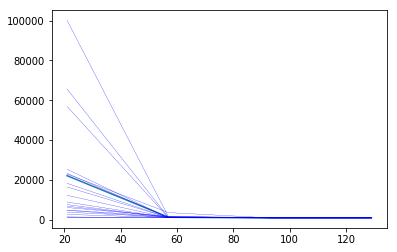

In [14]:
df = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".phi.actual.csv")))
ax = plt.subplot(111)
ax.plot(df.total_runs,df.loc[:,"mean"],lw=1.5)
j = [ax.plot(df.total_runs,df.loc[:,col], lw=0.25,color='b') for col in df.columns[7:]]

0.5 freyberg_kr/freyberg_kr.0.par.csv
b freyberg_kr/freyberg_kr.1.par.csv
g freyberg_kr/freyberg_kr.2.par.csv
r freyberg_kr/freyberg_kr.3.par.csv


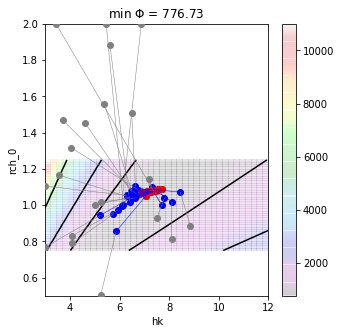

In [17]:
colors = ["0.5","b","g",'r']
#ax = plt.subplot(111)
#ax.set_xlabel("hk")
#ax.set_ylabel("rch_0")
#import response_surface as rs
#wd = os.path.join("..","freyberg_k_and_r_response_surface","freyberg_kr")
fig,ax = rs.plot_response_surface(parnames=["hk","rch_0"],
                                  pstfile=pst_name,
                                  WORKING_DIR=wd,alpha=0.1,
                                  label=False)

dfs = {}
for i,c in enumerate(colors):
    f = os.path.join(working_dir,pst_name.replace(".pst",".{0}.par.csv".format(i)))
    if not os.path.exists(f):
        continue
    print(c,f)
    df = pd.read_csv(f) 
    dfs[c] = df.loc[:,["HK","RCH_0"]]
    ax.scatter(df.HK,df.RCH_0,color=c,alpha=1.0,zorder=10)
    if i > 0:
        for ii in df.index:
            x = [df.loc[ii,"HK"],dflast.loc[ii,"HK"]]
            y = [df.loc[ii,"RCH_0"],dflast.loc[ii,"RCH_0"]]
            ax.plot(x,y,color=colors[i-1],lw=0.5,alpha=1.0,zorder=10)
    dflast = df
par = pst.parameter_data
ax.set_xlim(par.loc['hk',['parlbnd','parubnd']].values)
ax.set_ylim(par.loc['rch_0',['parlbnd','parubnd']].values)
plt.show()

### sweet as!

So we see each realization starts at a random location in the 2D parameter space (grey).  After the first update, the most realizations reproduce the observations much better (blue).  The final iterations (red and green) just polish...

### just for clarity

In [ ]:
deter_vals = pst.observation_data.loc[pst.nnz_obs_names,"obsval"].to_dict()
obs_base = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".base.obs.csv")))
obs_base.columns = obs_base.columns.str.lower()
obs_base = obs_base.loc[:,pst.nnz_obs_names]
pyemu.plot_utils.ensemble_helper(obs_base,deter_vals=deter_vals)

In [ ]:

pyemu.plot_utils.ensemble_helper(dfs,sync_bins=False,std_window=None)